# Opti Pipe

In [7]:
from opti_pipe import Model, Floor, Distributor,Node,NodeType, RoomConnection, Graph
from opti_pipe.utils import load_config
from opti_pipe.router import NaiveRouter

In [8]:
config = load_config()

In [9]:
floor = Floor(config=config,corners=[(0,0),(0,5),(5,5),(5,0)])

distributor = Distributor(config=config,nodes=(
    Node(config,2.25,0,node_type=NodeType.INPUT),
    Node(config,2.75,0,node_type=NodeType.INPUT),
    Node(config,3,0,node_type=NodeType.OUTPUT),
    Node(config,2,0,node_type=NodeType.OUTPUT)),
    heat_per_node=1)

room_connections = (RoomConnection(config,output=Node(config,0,3.5,node_type=NodeType.OUTPUT),input=Node(config,0,3.75,node_type=NodeType.INPUT),heat_loss=0.8),
                    RoomConnection(config,output=Node(config,5,3,node_type=NodeType.OUTPUT),input=Node(config,5,3.25,node_type=NodeType.INPUT),heat_loss=0.5))


In [10]:
model = Model(
    config = config,
    target_heat_input=100,
    floor=floor,
    distributor=distributor,
    room_connections=room_connections)

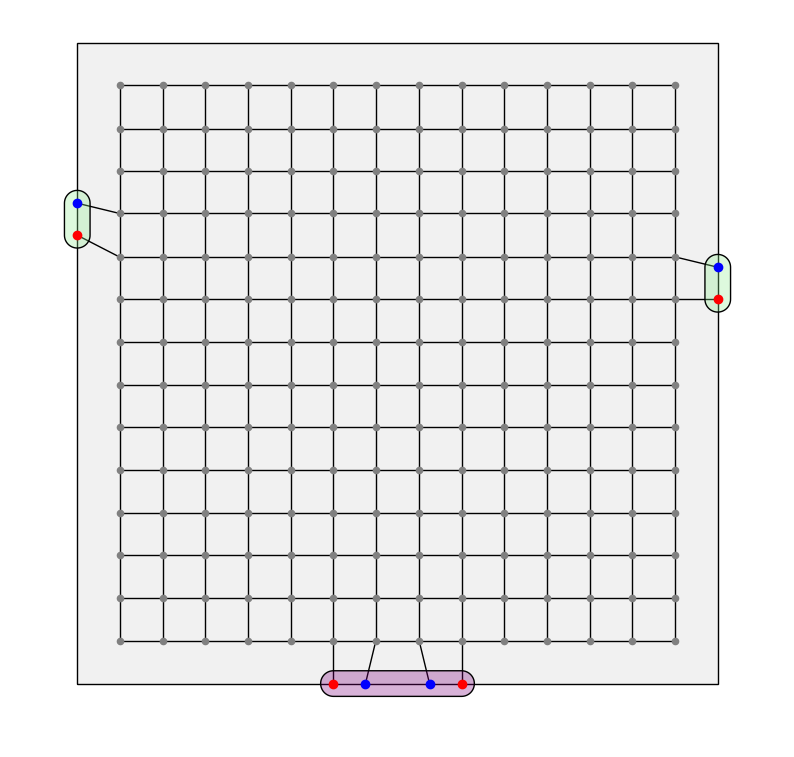

In [11]:

grid_size = 0.3
model.add_graph(grid_size)
model.render(show_graph=True)

In [12]:
model.pipes = tuple()
router = NaiveRouter(config,model,grid_size)
model = router.route()
model.render(show_graph=False)
# from opti_pipe.router import Utils
# line_string = Utils.get_centerline(model,grid_size)
# from shapely.plotting import plot_polygon
# plot_polygon(line_string)

StopIteration: 